# _Car Price Prediction_
**_Importing The Required Libraries & Packages_**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import pickle
import warnings
warnings.filterwarnings('ignore')

**_Changing The Default Working Directory & Path and Reading The Dataset Using Pandas Command_**

In [2]:
os.chdir('C:\\Users\\chand\\OneDrive\\Desktop\\Car Price Prediction\\')
df = pd.read_csv('dataset.csv')

## _Data Cleaning_
**_Viewing the dataset for identifying the unwanted columns_**

In [3]:
display(df.head())

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


**_Dropping the `Unnamed: 0`,`Location`and `New_Price` column since it is not much important for the prediction_**

In [4]:
df.drop(['Unnamed: 0','Location','New_Price'],axis=1,inplace=True)

**_Checking the Null values of all the Columns in the dataset_**

In [5]:
df.isnull().sum()

Name                  0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

**_There are several cars in the dataset,some of them with a count higher than 1.sometimes the resale value of a car also depends on manufacturer of the car. So, here extracting the manufacturer name from this column and adding it to the dataset_**

In [6]:
manufacturer = df['Name'].str.split(' ',expand=True)
df['Manufacturer'] = manufacturer[0]

**_The `Year` column from the datasethas no significance on its own so calculating  the years of cars used till now and adding it to the dataset._**

In [7]:
curr_time = datetime.datetime.now()
df['Year Used']=df['Year'].apply(lambda x:curr_time.year-x)

**_dropping the `Name` and `Year` columns since the needed data is extracted from it and added to the dataset in seperate columns as `Manufacturer` and `Year Used`_**

In [8]:
df.drop(['Name','Year'],axis=1,inplace=True)

**_The `Mileage` columns defines the mileage of the car which affects the price of the car during the sales. So that Extracting the numerical values from the `Mileage` column and since it has missing values,filling out the missing values with the mean & modifying the column with the values_** 

In [9]:
mileage = df['Mileage'].str.split(' ',expand=True)
df['Mileage'] = pd.to_numeric(mileage[0],errors='coerce')
df['Mileage'].fillna(df['Mileage'].astype('float').mean(),inplace=True)

**_The `Engine` columns has the CC of the car which affects the price of the car during the sales. So that removing CC and Extracting the numerical values from the `Engine` column and since it has missing values,filling out the missing values with the mean  modifying the column with the values_** 

In [10]:
engine = df['Engine'].str.split(' ',expand=True)
df['Engine']=pd.to_numeric(engine[0],errors='coerce')
df['Engine'].fillna(df['Engine'].astype('float').mean(),inplace=True)

**_The `Power` columns has the bhp of the car which affects the price of the car during the sales. So that removing bhp and Extracting the numerical values from the `Power` column and since it has missing values,filling out the missing values with the mean  modifying the column with the values_** 

In [11]:
power = df['Power'].str.split(' ',expand=True)
df['Power']=pd.to_numeric(power[0],errors='coerce')
df['Power'].fillna(df['Power'].astype('float').mean(),inplace=True)

**_since the `Seats` columns has some missing values filling out the missing values with the mean value of the same column_**

In [12]:
df['Seats'].fillna(df['Seats'].astype('float').mean(),inplace=True)

**_After Filling out the missing value with the appropriate values,checking for the null value in the dataset._**

In [13]:
df.isnull().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Manufacturer         0
Year Used            0
dtype: int64

## _Data Visualization_
**_Plotting the Bar Graph with count of cars based on the `Manufacturer` and confirm that there are no null values and identify all the unique values from the `Manufacturer` and saving the png file_**

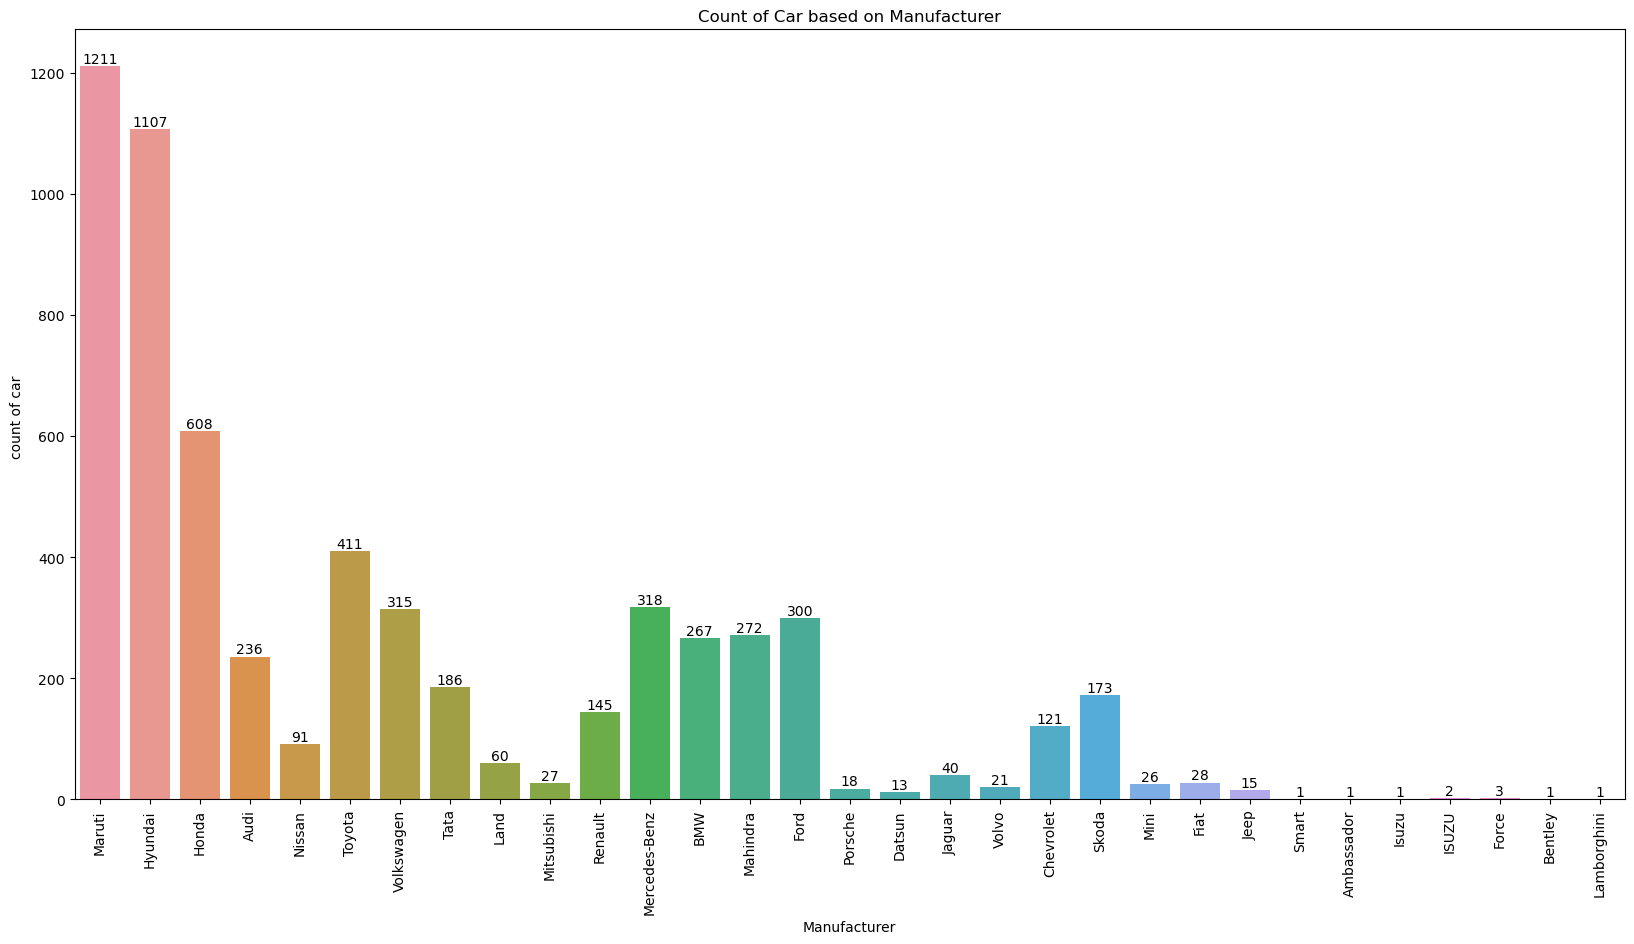

In [14]:
plt.rcParams['figure.figsize']=(20,10)
plot = sns.countplot(x='Manufacturer',data = df)
plt.xticks(rotation=90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2.0,p.get_height()),
                  ha='center',va='center',xytext=(0,5),textcoords='offset points')
plt.title('Count of Car based on Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('count of car ')
plt.savefig('Count of Car.png')
plt.show()

**_Getting the correlation value from all the numeric columns from the independent variable using seaborn Heatmap & saving the PNG file_**

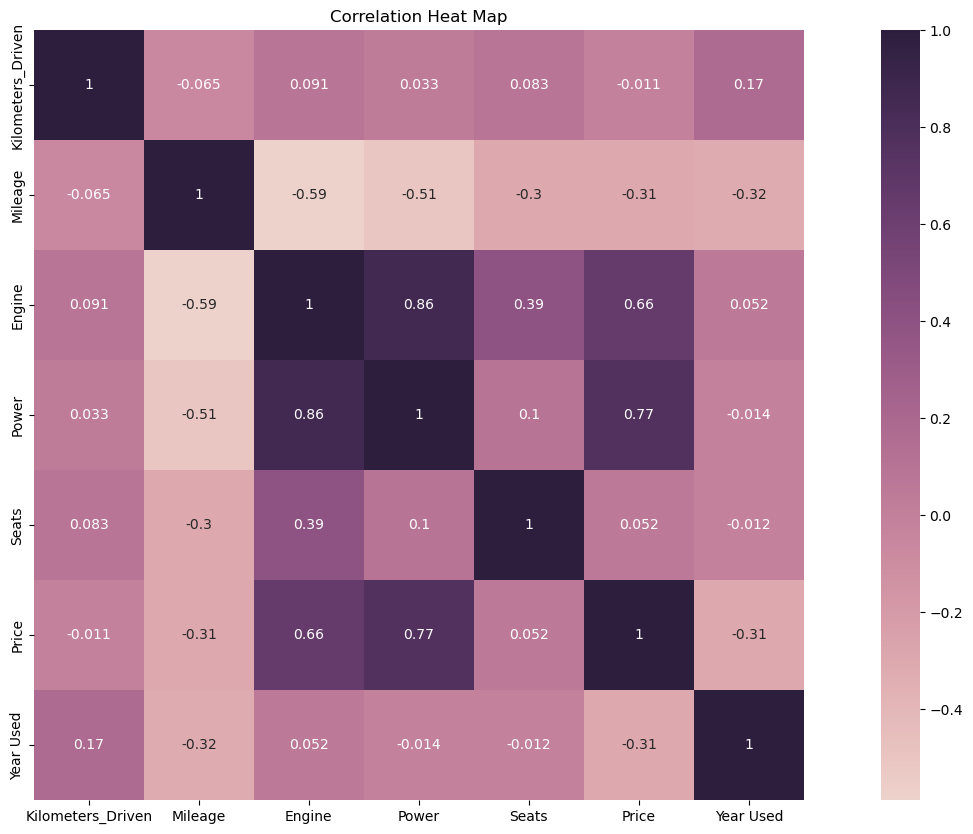

In [15]:
corr = df.corr()
sns.heatmap(corr,annot=True,cmap = sns.cubehelix_palette(as_cmap=True),cbar=True,square=True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

**_Assigning the dependent and independent variables_**

In [16]:
x = df.drop(['Price'],axis=1)
y = df['Price']

## _Data Preprocessing_
**_Splitting the dependent and independent variable into training and test dataset using train test split._**

In [17]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=45)

**_Creating the dummy columns for all the categorical columns such as `Manufacturer`,`Fuel_Type`,`Transmission`,`Owner_Type` in the training independent dataset and getting the dimensions of the training independent dataset for cross-check_**

In [18]:
x_train = pd.get_dummies(x_train,columns=['Manufacturer','Fuel_Type','Transmission','Owner_Type'],drop_first=True)
print(x_train.shape)

(4213, 42)


**_Creating the dummy columns for all the categorical columns such as `Manufacturer`,`Fuel_Type`,`Transmission`,`Owner_Type` in the test independent dataset and getting the dimensions of the test independent dataset for cross-check_**

In [19]:
x_test = pd.get_dummies(x_test,columns=['Manufacturer','Fuel_Type','Transmission','Owner_Type'],drop_first=True)
print(x_test.shape)

(1806, 38)


**_By the Dimensional checking its os evident that the dummy column creation is different in training and test independent data. so that filling in all the missing columns of the test independent data with 0._**

In [20]:
miss_col = set(x_train.columns)-set(x_test.columns)
for col in miss_col:
    x_test[col]=0
x_test = x_test[x_train.columns]

**_Now after processing,the dimensions of the column of both training and test independent data are same._**

In [21]:
print('X_train',x_train.shape)
print('X_test',x_test.shape)

X_train (4213, 42)
X_test (1806, 42)


**_Standardizing the independent variable of the dataset_**

In [22]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.fit_transform(x_test)

## _Model Fitting_
**_Defining the Function for the ML algorithms using GridSearchCV Algorithm and Predicting the Dependent Variable by fitting the given model and create the pickle file of the model with the given Algo_name. Further getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset._**

In [23]:
def FitModel(x,y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator=algorithm,param_grid=gridSearchParams,scoring='r2',verbose=0,cv=cv,n_jobs=-1)
    grid_result = grid.fit(x_train,y_train)
    best_params = grid_result.best_params_
    y_pred = grid_result.predict(x_test)
    pickle.dump(grid_result,open(algo_name,'wb'))
    print(' Algorithm Name:',algo_name)
    print('\n Best Params:',best_params)
    print('\n R2 Score:{}%'.format(100*r2_score(y_test,y_pred)))
    print('\n Mean Absolute Error:',mean_absolute_error(y_test,y_pred))
    print('\n Mean Squared Error:',mean_squared_error(y_test,y_pred))
    print('\n Root Mean Squared Error:',sqrt(mean_squared_error(y_test,y_pred)))

**_Running the function with empty parameters since the Linear Regression model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name Linear Regression._**

In [24]:
params = {}
FitModel(x,y,'Linear Regression',LinearRegression(),params,cv=10)

 Algorithm Name: Linear Regression

 Best Params: {}

 R2 Score:76.90457787320157%

 Mean Absolute Error: 2.9688979955213264

 Mean Squared Error: 28.66648456664555

 Root Mean Squared Error: 5.354109129131153


**_Running the function with empty parameters since the Lasso model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name Lasso._**

In [25]:
params = {}
FitModel(x,y,'Lasso',Lasso(),params,cv=10)

 Algorithm Name: Lasso

 Best Params: {}

 R2 Score:72.26180392554386%

 Mean Absolute Error: 3.3695924404312683

 Mean Squared Error: 34.42918537316263

 Root Mean Squared Error: 5.867638824362201


**_Running the function with empty parameters since the Ridge model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name Ridge._**

In [26]:
params = {}
FitModel(x,y,'Ridge',Ridge(),params,cv=10)

 Algorithm Name: Ridge

 Best Params: {}

 R2 Score:76.56033098690905%

 Mean Absolute Error: 2.9792346265441076

 Mean Squared Error: 29.09377045901163

 Root Mean Squared Error: 5.393864149106059


**_Running the function with empty parameters since the RandomForestRegressor model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name RandomForestRegressor._**

In [27]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Random Forest',RandomForestRegressor(),params,cv=10)

 Algorithm Name: Random Forest

 Best Params: {'n_estimators': 109, 'random_state': 45}

 R2 Score:89.16507697440488%

 Mean Absolute Error: 1.8262045776492803

 Mean Squared Error: 13.448515986794442

 Root Mean Squared Error: 3.6672218349582346


**_Running the function with empty parameters since the ExtraTreesRegressor model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name ExtraTreesRegressor._**

In [28]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)

 Algorithm Name: Extra Tree

 Best Params: {'n_estimators': 109, 'random_state': 45}

 R2 Score:91.1328292802006%

 Mean Absolute Error: 1.674786542310545

 Mean Squared Error: 11.006103772140824

 Root Mean Squared Error: 3.317544841014334


**_Running the function with empty parameters since the XGBRegressor model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name XGBRegressor._**

In [29]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'XG Boost',XGBRegressor(),params,cv=10)

 Algorithm Name: XG Boost

 Best Params: {'n_estimators': 44, 'random_state': 45}

 R2 Score:88.46083787618653%

 Mean Absolute Error: 1.8590134571748451

 Mean Squared Error: 14.322631174188217

 Root Mean Squared Error: 3.78452522440903


**_Running the function with empty parameters since the CatBoostRegressor model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name CatBoostRegressor._**

In [30]:
params = {}
FitModel(x,y,'Cat Boost',CatBoostRegressor(verbose=0),params,cv=10)

 Algorithm Name: Cat Boost

 Best Params: {}

 R2 Score:92.01917666078496%

 Mean Absolute Error: 1.6498705851737538

 Mean Squared Error: 9.905952263036088

 Root Mean Squared Error: 3.1473722790664738


**_Running the function with empty parameters since the LGBMRegressor model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name LGBMRegressor._**

In [31]:
params = {}
FitModel(x,y,'Light GBM',LGBMRegressor(),params,cv=10)

 Algorithm Name: Light GBM

 Best Params: {}

 R2 Score:88.81763190646117%

 Mean Absolute Error: 1.8329374062863661

 Mean Squared Error: 13.879771524072929

 Root Mean Squared Error: 3.725556538837242


## _Boosting the Model_
**_Defining the Function for the ML algorithms using GridSearchCV Algorithm and boosting the model using AdaBoostRegressor algorithm and Predicting the Dependent Variable by fitting the given model and create the pickle file of the model with the given Algo_name. Further getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset._**

In [32]:
def BoostModel(x,y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator=algorithm,param_grid=gridSearchParams,scoring='r2',verbose=0,cv=cv,n_jobs=-1)
    grid_result = grid.fit(x_train,y_train)
    AdaBoost = AdaBoostRegressor(base_estimator=grid_result,learning_rate=1)
    AdaBoost_result = AdaBoost.fit(x_train,y_train)
    y_pred = AdaBoost_result.predict(x_test)
    pickle.dump(AdaBoost_result,open(algo_name,'wb'))
    print(' Algorithm Name:',algo_name)
    print('\n R2 Score:{}%'.format(100*r2_score(y_test,y_pred)))
    print('\n Mean Absolute Error:',mean_absolute_error(y_test,y_pred))
    print('\n Mean Squared Error:',mean_squared_error(y_test,y_pred))
    print('\n Root Mean Squared Error:',sqrt(mean_squared_error(y_test,y_pred)))

**_Running the function with empty parameters since the Linear Regression model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name Linear Regression._**

In [33]:
params = {}
BoostModel(x,y,'Linear Regression',LinearRegression(),params,cv=10)

 Algorithm Name: Linear Regression

 R2 Score:-21.276385722418702%

 Mean Absolute Error: 8.198366741775613

 Mean Squared Error: 150.53059522026598

 Root Mean Squared Error: 12.269091051103418


**_Running the function with empty parameters since the Lasso model doesn't need any special parameters and fitting the Lasso Algorithm and getting the Algorithm Name, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name Lasso._**

In [34]:
params = {}
BoostModel(x,y,'Lasso',Lasso(),params,cv=10)

 Algorithm Name: Lasso

 R2 Score:46.588213458894664%

 Mean Absolute Error: 4.952642562366776

 Mean Squared Error: 66.2957423402511

 Root Mean Squared Error: 8.142219742812834


**_Running the function with empty parameters since the Ridge model doesn't need any special parameters and fitting the Ridge Algorithm and getting the Algorithm Name, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name Ridge._**

In [35]:
params = {}
BoostModel(x,y,'Ridge',Ridge(),params,cv=10)

 Algorithm Name: Ridge

 R2 Score:64.36436199299995%

 Mean Absolute Error: 3.6808781828019286

 Mean Squared Error: 44.23164302179591

 Root Mean Squared Error: 6.650687409719082


**_Running the function with some appropriate parameters and Boosting the Random Forest Regressor Algorithm  and getting the Algorithm Name, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name RandomForestRegressor._**

In [36]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
BoostModel(x,y,'Random Forest',RandomForestRegressor(),params,cv=10)

 Algorithm Name: Random Forest

 R2 Score:89.4899204020959%

 Mean Absolute Error: 1.7843019054763463

 Mean Squared Error: 13.045314042471658

 Root Mean Squared Error: 3.6118297360855283


**_Running the function with some appropriate parameters and Boosting the Extra Tree Regressor Algorithm  and getting the Algorithm Name, R2 Score in percentage format,mean absolute error ,mean squared error and rooted mean squared error between the predicted values and dependent test dataset and also the pickle file with the name RandomForestRegressor._**

In [37]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
BoostModel(x,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)

 Algorithm Name: Extra Tree

 R2 Score:91.52357306619938%

 Mean Absolute Error: 1.6537920177917995

 Mean Squared Error: 10.521105028695063

 Root Mean Squared Error: 3.243625291043197


**_For Further prediction use the model with the highest r2_score and load the pickle file with the format as `pickle.load(open(algo_name,'rb'))`_**